# Project 8: Time Series Forecasting

## Introduction

Time series analysis is an essential field in data science and statistics, focusing on the study of data points collected or recorded at specific time intervals. By examining patterns and trends in time-based data, time series analysis enables us to make informed predictions, which can be applied to various domains, from finance and economics to meteorology and natural sciences.

In this notebook, we will delve into the fundamentals of time series analysis, using the historical data on sunspot activity as our dataset. Sunspots, which are temporary phenomena on the Sun's surface, provide a fascinating example of natural cyclic data and have been recorded for centuries. Our objective will be to explore this data, analyze underlying trends, and build predictive models to forecast future sunspot occurrences.


## Objectives

This notebook aims to provide a comprehensive understanding of time series analysis and forecasting using Python. By the end of this notebook, you will be able to:

1. Understand the Structure of Time Series Data
1. Prepare and Visualize Time Series Data
1. Decompose Time Series Data
1. Develop Time Series Models
1. Evaluate Model Performance

## Dataset: Sunspot Activity (sunspots.csv)
The dataset we’ll use, sunspots.csv, contains historical records of sunspot counts over time. Sunspots are particularly interesting in time series analysis due to their cyclical nature, allowing us to capture seasonal patterns and long-term trends.

Data Source: The sunspot dataset is a classic time series data, often used in forecasting studies.

In [133]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.optim as optim
from torch import nn
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import mean_absolute_error

%matplotlib inline


In [134]:
train_on_gpu = torch.cuda.is_available()
device = torch.device("cuda" if train_on_gpu else "cpu")
if train_on_gpu:
    print("Training on GPU.")
else:
    print("GPU unavailable, training on CPU.")

Training on GPU.


In [135]:
# Set random seed for reproducibility
seed = 999
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
np.random.seed(seed)

In [136]:
sunspots_df = pd.read_csv("data/sunspots.csv")
print(sunspots_df.head(5))

   Unnamed: 0        Date  Monthly Mean Total Sunspot Number
0           0  1749-01-31                               96.7
1           1  1749-02-28                              104.3
2           2  1749-03-31                              116.7
3           3  1749-04-30                               92.8
4           4  1749-05-31                              141.7


## Prepare and visualize our time series

In this section, we will visualize our time series. In the code below, we will plot our monthly mean total sunspot number in function of the index of each month.

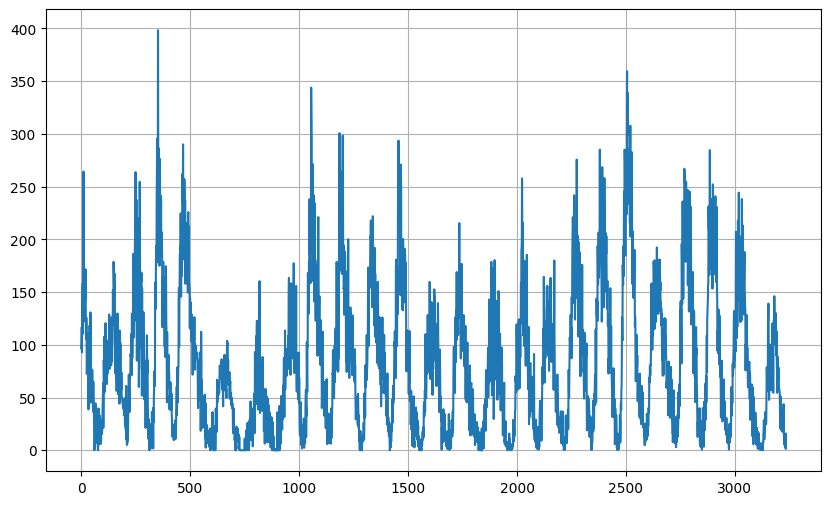

In [137]:
SERIES_COL = "Monthly Mean Total Sunspot Number"

time_step = sunspots_df.iloc[:, 0]
series = sunspots_df[SERIES_COL]

plt.figure(figsize=(10, 6))
plt.plot(time_step, series)
plt.grid(True)

## Splitting the dataset

With our data loaded and visualized, we can now proceed to split the dataset into training and validation sets. For this project, we’ll use the first 3,000 samples for training, reserving the remaining 200+ samples for testing. This split ensures a robust training phase while leaving enough data to evaluate model performance on unseen data.

**In forecasting, we typically use a contiguous block of past data for training and a more recent block for validation.**

In [138]:
split_idx = 3000
time_train = time_step[:split_idx]
x_train = series[:split_idx]
time_valid = time_step[split_idx:]
x_valid = series[split_idx:]

The windowed_dataset function prepares time series data for forecasting by creating sliding windows and their corresponding labels. It reshapes the input series, generates windows of past values as inputs, and shifts them to produce labels as future sequences. The function returns a PyTorch DataLoader for efficient batch loading and shuffling, making it suitable for training models like LSTMs and Transformers.

In [139]:
def windowed_dataset(series, window_size, batch_size, shuffle=True):
    # Ensure the series is a 2D array (with a single feature dimension)
    series = np.expand_dims(series, axis=-1)
    # Prepare windows and labels
    windows = []
    labels = []
    for i in range(len(series) - window_size):
        windows_tensor = torch.tensor(
            series[i : i + window_size],
            dtype=torch.float32,
        )
        labels_tensor = torch.tensor(
            series[i + 1 : i + window_size + 1],
            dtype=torch.float32,
        )
        windows.append(windows_tensor)
        labels.append(labels_tensor)
    # Create a dataset and a DataLoader with shuffling and batching
    dataset = TensorDataset(
        torch.stack(windows),
        torch.stack(labels),
    )
    dataloader = DataLoader(
        dataset,
        batch_size=batch_size,
        shuffle=shuffle,
        drop_last=True,
    )
    return dataloader

In time series forecasting, preparing the dataset in a windowed format is essential because it provides the model with short sequences of past values (or "windows") that it can use to predict future values. This procedure creates a structured dataset that is well-suited to training models like LSTMs and Transformers, which excel at learning from sequential data.

This approach ensures that the model is trained on sequences that mimic the structure of the data it will encounter in forecasting, allowing it to capture dependencies across time steps and improve its predictive accuracy.


In [140]:
window_size = 30
batch_size = 50
train_set = windowed_dataset(x_train, window_size, batch_size)
valid_set = windowed_dataset(x_valid, window_size, batch_size)
print(train_set)
print(x_train.shape)
print(valid_set)
print(x_valid.shape)

(3000,)
(235,)


## Model Overview

Our model combines a 1D convolutional layer (Conv1D) with an LSTM layer and several fully connected (linear) layers to process and learn temporal dependencies in sequential data.

1. 1D Convolutional Layer (conv1d):
    - Extracts local patterns or features from the input time series.
1. LSTM Layer (lstm):
    - Captures sequential dependencies in the data using Long Short-Term Memory (LSTM) cells.
1. Fully Connected Layers (fc1, fc2, and fc3):
    - After extracting features from the LSTM, these layers perform additional transformations for regression.

- Initialization of Hidden State (init_hidden):
    - This function initializes the LSTM’s hidden state for a given batch size, ensuring compatibility with the model’s architecture. It returns a tuple of zero-filled tensors, one for the hidden state and one for the cell state.

- Forward Pass (forward):
1. Input: The input tensor x with shape (batch_size, seq_len, 1) and an initial hidden state.
1. Processing Steps:
    - The input tensor is permuted to match the expected input shape of conv1d.
    - conv1d applies a convolutional operation, followed by a ReLU activation.
    - The output is rearranged for compatibility with the LSTM layer.
    - The LSTM processes the data sequentially, updating the hidden state at each timestep.
    - Only the last timestep’s output is passed through the fully connected layers for the final forecast.
1. Output: The model returns the forecasted value and the updated hidden state.

This design leverages both convolutional and recurrent layers to effectively capture temporal patterns, making it suitable for tasks where time-dependent feature extraction and sequence modeling are critical.



In [141]:
class ForecastingModel(nn.Module):
    def __init__(self, n_layers, hidden_dim) -> None:
        super(ForecastingModel, self).__init__()
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.conv1d = nn.Conv1d(
            in_channels=1,
            out_channels=32,
            kernel_size=5,
            stride=1,
        )
        self.lstm = nn.LSTM(
            input_size=32,
            hidden_size=hidden_dim,
            num_layers=n_layers,
            batch_first=True,
        )
        self.fc1 = nn.Linear(64, 30)
        self.fc2 = nn.Linear(30, 10)
        self.fc3 = nn.Linear(10, 1)

    def init_hidden(self, batch_size):
        """Initializes hidden state for LSTM"""
        hidden = (
            torch.zeros(self.n_layers, batch_size, self.hidden_dim, device=device),
            torch.zeros(self.n_layers, batch_size, self.hidden_dim, device=device),
        )
        return hidden

    def forward(self, x, hidden):
        x = x.permute(0, 2, 1)
        # Pass through 1D convolution
        x = self.conv1d(x)  # Output shape: (batch_size, 32, seq_len)
        # Apply ReLU activation
        x = torch.relu(x)
        # Reorganize dimensions for LSTM
        x = x.permute(0, 2, 1)
        # Pass through first LSTM layer
        x, hidden = self.lstm(x, hidden)  # Output shape: (batch_size, seq_len, 64)
        # Take the last output from LSTM (last timestep)
        x = x[:, -1, :]  # Output shape: (batch_size, 64)
        # Pass through fully connected layers with ReLU activations
        x = torch.relu(self.fc1(x))  # Output shape: (batch_size, 30)
        x = torch.relu(self.fc2(x))  # Output shape: (batch_size, 10)
        x = self.fc3(x)  # Output shape: (batch_size, 1)
        return x, hidden  # Return both the output and the hidden state

## Model initialization, Optimizer, and Loss Function setup

In this section, we initialize the ForecastingModel and set up the optimizer and loss function to train the model effectively.

1. Model initialization:

    `model = ForecastingModel(n_layers=2, hidden_dim=64).to(device)`

- This instantiates our forecasting model with 2 LSTM layers (n_layers=2) and a hidden dimension of 64 (hidden_dim=64). These parameters control the complexity and depth of the model, helping it learn temporal dependencies in the data.

1. Optimizer Setup:

    `optimizer = optim.AdamW(model.parameters(), lr=1e-4)`

- AdamW Optimizer: We use the AdamW optimizer, an improved version of Adam that includes weight decay for better regularization, preventing overfitting. It’s well-suited for training neural networks on complex data.
- Learning Rate (lr=1e-4): A learning rate of 0.0001 defines the step size in gradient descent, controlling how much the model updates its parameters during training. This rate is often effective for fine-tuning models.

1. Loss Function:

    `criterion = nn.HuberLoss()`

- Huber Loss: The Huber loss is chosen as the loss function for model training. It’s a robust option that combines mean squared error and mean absolute error, balancing sensitivity to outliers and stability during training. This makes it suitable for regression tasks like time series forecasting, where occasional large errors may be present.

In [142]:
# Initialize the model, optimizer, and loss function
model = ForecastingModel(n_layers=2, hidden_dim=64).to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4)
criterion = nn.HuberLoss()

## Training our model

The train_model function defines the training loop for the ForecastingModel. It takes the model, training and validation data loaders, optimizer, loss function, and the number of epochs as input. Every 10 epochs, the function prints the training and validation losses to track the progress. 

In [143]:
def train_model(model, train_loader, valid_loader, optimizer, criterion, num_epochs=20):
    training_loss = []
    validation_loss = []
    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        h = model.init_hidden(batch_size)
        total_train_loss = 0
        for x_batch, y_batch in train_loader:
            # Move data to the appropriate device
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            # Zero the gradients for this batch
            optimizer.zero_grad()
            # Detach hidden states to clear the computation history
            h = tuple(each.detach() for each in h)
            # Forward pass: make predictions based on current model parameters
            output, h = model(x_batch, h)
            # Compute the loss
            loss = criterion(
                output, y_batch[:, -1, :]
            )  # Use the last value as the label
            total_train_loss += loss.item()
            # Backward pass: compute gradients
            loss.backward()
            # Update the parameters
            optimizer.step()
        # Print training stats
        avg_train_loss = total_train_loss / len(train_loader)
        # Validation phase (optional)
        model.eval()  # Set the model to evaluation mode
        h = model.init_hidden(batch_size)
        with torch.no_grad():
            total_valid_loss = 0
            for x_batch, y_batch in valid_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                output, h = model(x_batch, h)
                loss = criterion(
                    output, y_batch[:, -1, :]
                )  # Use the last value as the label
                total_valid_loss += loss.item()
            avg_valid_loss = total_valid_loss / len(valid_loader)
        training_loss.append(avg_train_loss)
        validation_loss.append(avg_valid_loss)
        if (epoch + 1) % 10 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}],", end=" ")
            print(f"Train Loss: {avg_train_loss:.4f},", end=" ")
            print(f"Validation Loss: {avg_valid_loss:.4f}")
    return training_loss, validation_loss

In [144]:
num_epochs = 50
training_loss, validation_loss = train_model(
    model,
    train_set,
    valid_set,
    optimizer,
    criterion,
    num_epochs=num_epochs,
)

Epoch [10/50], Train Loss: 71.8388, Validation Loss: 50.0518
Epoch [20/50], Train Loss: 47.5742, Validation Loss: 28.8271
Epoch [30/50], Train Loss: 29.1437, Validation Loss: 18.0243
Epoch [40/50], Train Loss: 21.2652, Validation Loss: 13.4887
Epoch [50/50], Train Loss: 18.0557, Validation Loss: 12.9020


## Using the model

The model_forecast function is designed to generate predictions (forecasts) from a trained model on a given time series dataset. It processes the input series in batches, computes forecasts, and returns the predicted and true values.

In [145]:
def model_forecast(model, series, window_size):
    x_data = windowed_dataset(series, window_size, batch_size, shuffle=False)
    model.eval()  # Set the model to evaluation mode
    h = model.init_hidden(batch_size)
    forecast = []
    true_labels = []
    with torch.no_grad():
        for x_batch, y_batch in x_data:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            output, h = model(x_batch, h)
            forecast.append(output.cpu().numpy())
            true_labels.append(y_batch[:, -1, :].cpu().numpy())
    forecast = np.concatenate(forecast, axis=0).flatten()
    true_labels = np.concatenate(true_labels, axis=0).flatten()
    return forecast, true_labels

The evaluate_mae function evaluates the model's performance using Mean Absolute Error (MAE) on the validation dataset. This pipeline provides a straightforward way to assess the model's accuracy by comparing its forecasts against the actual values in the validation data.

In [146]:
def evaluate_mae(model, valid_loader):
    forecast, true_labels = model_forecast(model, valid_loader, window_size)
    mae = mean_absolute_error(forecast, true_labels)
    print(f"Validation MAE: {mae:.4f}")

In [147]:
evaluate_mae(model, x_valid)

Validation MAE: 13.7355


## Loss Visualization

The visualize_losses function generates side-by-side plots to visualize the training and validation loss over epochs. This function provides a clear visual representation of how the model's performance evolves during training and evaluation.

In [ ]:
def visualize_losses(training_loss, validation_loss):
    plt.figure(figsize=(12, 6))
    # Plot for training loss
    plt.subplot(1, 2, 1)  # 1 row, 2 columns, plot 1
    plt.plot(training_loss, color="blue", label="Training Loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()
    # Plot for validation loss
    plt.subplot(1, 2, 2)  # 1 row, 2 columns, plot 2
    plt.plot(validation_loss, color="red", label="Validation Loss")
    plt.title("Validation Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.grid(True)
    plt.legend()

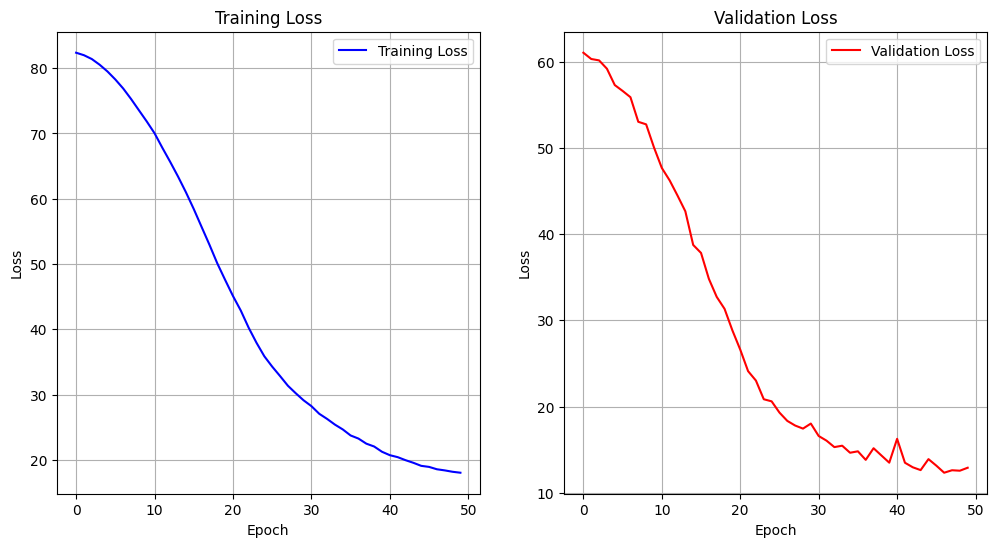

In [149]:
visualize_losses(training_loss, validation_loss)

## Visualize Predictions

The visualize_classification_predictions function visualizes the model's classification predictions. It calls the model_forecast function to obtain the model’s predictions (forecast) and the true labels (true_labels) from the validation data, then creates a plot with the true labels and predicted values, allowing a visual comparison of the model’s performance.

This function provides a simple way to visualize how well the model's predictions match the actual labels over time.

In [ ]:
def visualize_classification_predictions(model, valid_loader):
    forecast, true_labels = model_forecast(model, valid_loader, window_size)
    time_ticks = range(split_idx, split_idx + len(forecast))
    plt.figure(figsize=(12, 6))
    plt.plot(time_ticks, true_labels, label="Real Data")
    plt.plot(time_ticks, forecast, label="Predicted Data")
    plt.title("Predicted Data x Real Data")
    plt.xlabel("Time step")
    plt.ylabel("Prediction")
    plt.grid(True)
    plt.legend()

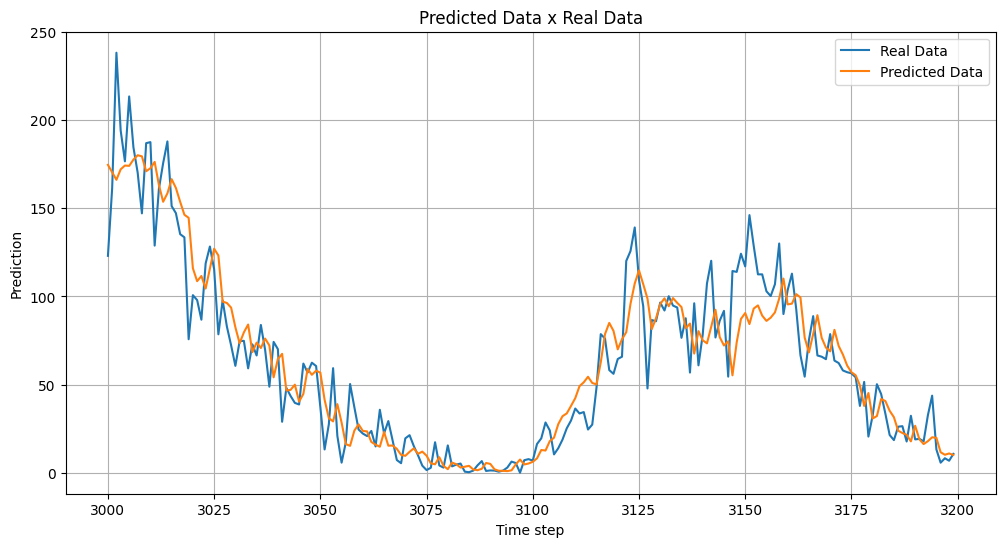

In [151]:
visualize_classification_predictions(model, x_valid)